<a href="https://colab.research.google.com/github/WhiteHum/Medical-AI-Deep-Learning-Drug-Toxicitiy-Prediction-/blob/main/05_Drug_target_interaction(DTI)_prediction_using_Sequence_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## 공유 폴더 내 드라이브에 바로가기 추가하기

# 드라이브 마운트 하기
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


데이터 준비하기

데이터 불러오기

In [ ]:
# 필요한 라이브러리 불러오기

import os
import pandas as pd
import json
import numpy as np

In [ ]:
# 공유 폴더에 저장된 데이터 현재 폴더에 압축 풀기
!unzip /content/drive/MyDrive/패스트캠퍼스/Part3/실습/DAVIS.zip

Archive:  /content/drive/MyDrive/패스트캠퍼스/Part3/실습/DAVIS.zip
replace DAVIS/affinity.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: DAVIS/affinity.txt      
  inflating: __MACOSX/DAVIS/._affinity.txt  
  inflating: DAVIS/SMILES.txt        
  inflating: __MACOSX/DAVIS/._SMILES.txt  
  inflating: DAVIS/target_seq.txt    
  inflating: __MACOSX/DAVIS/._target_seq.txt  


In [ ]:
# drug - target biniding affinity 데이터

affinity = pd.read_csv('/content/DAVIS/affinity.txt', header=None, sep=' ')

# Target protein sequence 데이터
with open('/content/DAVIS/target_seq.txt') as f:
  target = json.load(f)
  target = list(target.values())

# Drug SMILES 데이터
with open('/content/DAVIS/SMILES.txt') as f:
  drug = json.load(f)
  drug = list(drug.values())
  

데이터 탐색 (Exploratory data analysis)

Binding Affiniry

In [ ]:
affinity.shape

# 행(row) : drugs
# 열(col) : target

(68, 442)

In [ ]:
affinity.head()

,0,1,2,3,4,5,6,7,8,9,...,432,433,434,435,436,437,438,439,440,441
0,43.0,10000.0,10000.0,10000.0,10000.00,10000.0,10000.0,10000.0,10000.0,10000.00,...,10000,10000,10000,10000,10000,10000.0,10000,230.0,10000.0,10000
1,10000.0,10000.0,10000.0,10000.0,10000.00,10000.0,10000.0,10000.0,10000.0,10000.00,...,10000,10000,10000,10000,10000,10000.0,10000,2000.0,10000.0,10000
2,10000.0,75.0,1.9,13.0,0.77,13.0,2.6,31.0,34.0,0.93,...,10000,10000,10000,10000,10000,260.0,1200,120.0,2.3,10000
3,10000.0,10000.0,10000.0,10000.0,10000.00,10000.0,10000.0,10000.0,10000.0,10000.00,...,10000,10000,10000,10000,10000,10000.0,10000,10000.0,10000.0,10000
4,10000.0,420.0,2900.0,750.0,580.00,230.0,500.0,500.0,1200.0,790.00,...,10000,10000,10000,10000,10000,10000.0,10000,10000.0,10000.0,10000


In [ ]:
affinity.describe()

,0,1,2,3,4,5,6,7,8,9,...,432,433,434,435,436,437,438,439,440,441
count,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,...,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000
mean,6305.710294,4786.038882,6776.396029,6157.742956,5368.200176,5076.213941,3662.326721,4603.582397,4621.454015,4351.749309,...,8199.426471,9174.279412,8509.647059,8989.588235,9681.838235,5118.126471,8046.602941,3241.946765,6886.200000,8798.838235
std,4502.267160,4755.621867,4071.977775,4317.135465,4538.166881,4586.191949,4403.584967,4605.842183,4752.974206,4717.341321,...,3384.862965,2458.183712,3181.048615,2741.635062,1683.615935,4627.492704,3430.533809,4272.287089,4264.491886,2973.932873
min,1.200000,0.047000,0.100000,0.041000,0.032000,0.019000,0.025000,0.046000,0.016000,0.037000,...,71.000000,57.000000,13.000000,24.000000,55.000000,0.300000,12.000000,0.520000,2.300000,16.000000
25%,892.500000,123.750000,2775.000000,1075.000000,632.500000,270.000000,45.000000,64.000000,59.000000,99.250000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,260.000000,7100.000000,50.250000,1775.000000,10000.000000
50%,10000.000000,2050.000000,10000.000000,10000.000000,4250.000000,2800.000000,960.000000,2500.000000,1800.000000,865.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,4350.000000,10000.000000,490.000000,10000.000000,10000.000000
75%,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
max,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000


Target protein & Drug

In [ ]:
print(f'총 protin 개수 : {len(target)}')
print(f'총 drug 개수 : {len(drug)}')

총 protin 개수 : 442
총 drug 개수 : 68


In [ ]:
print('Target protein sequence 예시 : ')
print(target[0])
print('Drug SMILES 예시:  ')
print(drug[0])

Target protein sequence 예시 : 
MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQVTVDEVLAEGGFAIVFLVRTSNGMKCALKRMFVNNEHDLQVCKREIQIMRDLSGHKNIVGYIDSSINNVSSGDVWEVLILMDFCRGGQVVNLMNQRLQTGFTENEVLQIFCDTCEAVARLHQCKTPIIHRDLKVENILLHDRGHYVLCDFGSATNKFQNPQTEGVNAVEDEIKKYTTLSYRAPEMVNLYSGKIITTKADIWALGCLLYKLCYFTLPFGESQVAICDGNFTIPDNSRYSQDMHCLIRYMLEPDPDKRPDIYQVSYFSFKLLKKECPIPNVQNSPIPAKLPEPVKASEAAAKKTQPKARLTDPIPTTETSIAPRQRPKAGQTQPNPGILPIQPALTPRKRATVQPPPQAAGSSNQPGLLASVPQPKPQAPPSQPLPQTQAKQPQAPPTPQQTPSTQAQGLPAQAQATPQHQQQLFLKQQQQQQQPPPAQQQPAGTFYQQQQAQTQQFQAVHPATQKPAIAQFPVVSQGGSQQQLMQNFYQQQQQQQQQQQQQQLATALHQQQLMTQQAALQQKPTMAAGQQPQPQPAAAPQPAPAQEPAIQAPVRQQPKVQTTPPPAVQGQKVGSLTPPSSPKTQRAGHRRILSDVTHSAVFGVPASKSTQLLQAAAAEASLNKSKSATTTPSGSPRTSQQNVYNPSEGSTWNPFDDDNFSKLTAEELLNKDFAKLGEGKHPEKLGGSAESLIPGFQSTQGDAFATTSFSAGTAEKRKGGQTVDSGLPLLSVSDPFIPLQVPDAPEKLIEGLKSPDTSLLLPDLLPMTDPFGSTSDAVIEKADVAVESLIPGLEPPVPQRLPSQTESVTSNRTDSLTGEDSLLDCSLLSNPTTDLLEEFAPTAISAPVHKAAEDSNLISGFDVPEGSDKVAEDEFDPIPVLITKNPQGGHSRNSSGSSESSLPNLARSLLLVDQLIDL
Drug SMI

데이터 전처리

데이터 프레임 만들기

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
# SMILES - Target - Affinity paired list 만들기

SMILES = []
Target_seq = []
y = []

for i in range(len(drug)):
  for j in range(len(target)):
    SMILES.append(drug[i])
    Target_seq.append(target[j])
    y.append(affinity.values[i, j])

In [ ]:
# Binding affinity cutoff로 affinity  이진화 (binary)하기

threshold = 300 #Binding affinity cutoff

y = [1 if i else 0 for i in np.array(y) < threshold]

In [ ]:
# 모든 데이터 하나의 데이터 프레임으로 만들기

All_Data_dictionary = { 'SMILES': SMILES, 'Target Sequence' : Target_seq, 'Label': y}
df_data = pd.DataFrame(All_Data_dictionary)

In [ ]:
df_data

,SMILES,Target Sequence,Label
0,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQV...,1
1,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,0
2,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,0
3,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,0
4,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,0
...,...,...,...
30051,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,MGCIKSKENKSPAIKYRPENTPEPVSTSVSHYGAEPTTVSPCPSSS...,0
30052,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,MAHLRGFANQHSRVDPEELFTKLDRIGKGSFGEVYKGIDNHTKEVV...,0
30053,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,MSSMPKPERHAESLLDICHDTNSSPTDLMTVTKNQNIILQSISRSE...,0
30054,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,MSSLGASFVQIKFDDLQFFENCGGGSFGSVYRAKWISQDKEVAVKK...,0


In [ ]:
print(f'전체 drug-target pair 수 : {str(len(df_data))}')

전체 drug-target pair 수 : 30056


In [ ]:
# Lable 비율 확인

import seaborn as sns
import matplotlib.pyplot as plt

counts = df_data['Label'].value_counts() # label counts
counts

0    26434
1     3622
Name: Label, dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Counts')

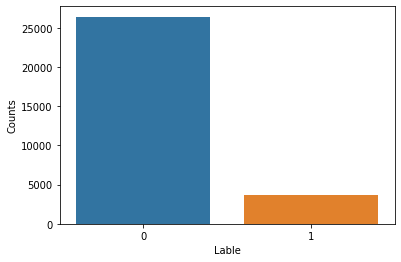

In [ ]:
x = np.array([0,1])

ax = plt.subplot()
sns.barplot(x, counts)
ax.set_xticks(x)

plt.xlabel('Lable')
plt.ylabel('Counts')

학습에 사용할 수 있도록 데이터 정제

In [ ]:
# 아미노산 charater 정의
amino_char = ['?', 'A', 'C', 'B', 'E', 'D', 'G', 'F', 'I', 'H', 'K', 'M', 'L', 'O',
       'N', 'Q', 'P', 'S', 'R', 'U', 'T', 'W', 'V', 'Y', 'X', 'Z']

# SMILES character 정의
smiles_char = ['?', '#', '%', ')', '(', '+', '-', '.', '1', '0', '3', '2', '5', '4',
       '7', '6', '9', '8', '=', 'A', 'C', 'B', 'E', 'D', 'G', 'F', 'I',
       'H', 'K', 'M', 'L', 'O', 'N', 'P', 'S', 'R', 'U', 'T', 'W', 'V',
       'Y', '[', 'Z', ']', '_', 'a', 'c', 'b', 'e', 'd', 'g', 'f', 'i',
       'h', 'm', 'l', 'o', 'n', 's', 'r', 'u', 't', 'y']

# protein, drug 원핫(one-hot) 인코더
enc_protein = OneHotEncoder().fit(np.array(amino_char).reshape(-1, 1))
enc_drug = OneHotEncoder().fit(np.array(smiles_char).reshape(-1,1))

# Protein 최대 길이
MAX_SEQ_PROTEIN = 1000

# Drug 최대 길이
MAX_SEQ_DRUG = 100

In [ ]:
# SMILES 데이터 전처리 하기

# 같은 크기(MAX_SEQ_DRUG)의 리스트로 만들기
# 사전 정의 된 character에 할당되지 않는 값 => ? 로 변환
# x : 하나의 SMILES 데이터 (string)
# return : 전처리된 SMILES 데이터 리스트

def trans_drug(x):
  temp = list(x) # str => list
  temp = [i if i in smiles_char else '?' for i in temp] # 사전 정의된  character에 없으면 ?로 변환

  if len(temp) < MAX_SEQ_DRUG:
   # MAX_SEQ_DRUG보다 작으면 뒷부분을 ?로 채워서 MAX_SEQ_DRUG 길이의 리스트로  만들기
    temp = temp + ['?'] * (MAX_SEQ_DRUG-len(temp))
  else :
    # MAX_SEQ_DRUG 보다 크면 앞에서부터 MAX_SEQ_DRUG 만큼 슬라이싱
    temp = temp[:MAX_SEQ_DRUG]

  return temp

In [ ]:
# Protein sequence 데이터 전처리 하기

# 같은 크기(MAX_SEQ_PROTEIN)의 리스트로 만들기
# 사전 정의된 character에 해당되지 않는 값은 ? 로 변환
# x  하나의 sequence 데이터 (string)
# return  전처리된 SMILES 데이터 리스트

def trans_protein(x):

  temp = list(x.upper()) # 대문자로 바꾸기
  temp = [i if i in amino_char else '?' for i in temp]

  if len(temp) <MAX_SEQ_PROTEIN:
    # MAX_SEQ_PROTEIN보다 작으면 뒷부분을 ? 로 채워서 MAX_SEQ_PROTEIN 길이의 리스트로 만들기
    temp = temp + ['?'] * (MAX_SEQ_PROTEIN-len(temp))
  else : 
    # MAX_SEQ_PROTEIN보다 크면 앞에서부터 MAX_SEQ_PROTEIN 만큼 슬라이싱
    temp = temp[:MAX_SEQ_PROTEIN]
  return temp

In [ ]:
# Drug  데이터 중 중복되지 않는 것만 processing
unique_drug = pd.Series(df_data['SMILES'].unique()).apply(trans_drug)

# raw SMILES - porcessed SMILES 딕셔너리
unique_dict = dict(zip(df_data['SMILES'].unique(), unique_drug ))

# 전체 데이터 processing
df_data['drug_encoding'] = [unique_dict[i] for i in df_data['SMILES']]


In [ ]:
# Protein 데이터 중 중복되지 않는 것만 processing

AA = pd.Series(df_data['Target Sequence'].unique()).apply(trans_protein)

# raw protein - processed protein 딕셔너리
AA_dict = dict(zip(df_data['Target Sequence'].unique(), AA))

# 전체 데이터 processing
df_data['target_encoding']= [AA_dict[i] for i in df_data['Target Sequence']]

데이터 나누기

In [ ]:
# df : 전체 데이터 (Pandas DataFrame)
# fold_seed : random_state for random sampling
# frac : train - val - test fraction (list or tuple)
# returns : Train / Val / Test dataframe (tuple)

def create_fold(df, fold_seed, frac) :
  train_frac, val_frac, test_frac = frac

  # Test 데이터 random sampling
  test = df.sample(frac = test_frac, replace = False, random_state = fold_seed)
  train_val = df[~df.index.isin(test.index)] # Train & Validation 데이터

  # Validation 데이터 random sampling
  val = train_val.sample(frac = val_frac / (1-test_frac), replace = False, random_state = 1)
  train = train_val[~train_val.index.isin(val.index)] # Train 데이터

  return train, val, test

In [ ]:
train, val, test = create_fold(df_data, 22, [0.7, 0.1, 0.2])

In [ ]:
# 잘 나누어 졌는지 확인

print(f'Train 데이터 크기 : {len(train)}')
print(f'Validation 데이터 크기 : {len(val)}')
print(f'Test 데이터 크기 : {len(test)}')

Train 데이터 크기 : 21039
Validation 데이터 크기 : 3006
Test 데이터 크기 : 6011


In [ ]:
train

,SMILES,Target Sequence,Label,drug_encoding,target_encoding
2,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,0,"[C, C, 1, =, C, 2, C, =, C, (, C, =, C, C, 2, ...","[P, F, W, K, I, L, N, P, L, L, E, R, G, T, Y, ..."
5,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,0,"[C, C, 1, =, C, 2, C, =, C, (, C, =, C, C, 2, ...","[P, F, W, K, I, L, N, P, L, L, E, R, G, T, Y, ..."
6,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,0,"[C, C, 1, =, C, 2, C, =, C, (, C, =, C, C, 2, ...","[P, F, W, K, I, L, N, P, L, L, E, R, G, T, Y, ..."
7,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,0,"[C, C, 1, =, C, 2, C, =, C, (, C, =, C, C, 2, ...","[P, F, W, K, I, L, N, P, L, L, E, R, G, T, Y, ..."
9,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,0,"[C, C, 1, =, C, 2, C, =, C, (, C, =, C, C, 2, ...","[P, F, W, K, I, L, N, P, L, L, E, R, G, T, Y, ..."
...,...,...,...,...,...
30049,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,MGGNHSHKPPVFDENEEVNFDHFQILRAIGKGSFGKVCIVQKRDTK...,0,"[C, 1, =, C, C, =, C, 2, C, (, =, C, 1, ), C, ...","[M, G, G, N, H, S, H, K, P, P, V, F, D, E, N, ..."
30051,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,MGCIKSKENKSPAIKYRPENTPEPVSTSVSHYGAEPTTVSPCPSSS...,0,"[C, 1, =, C, C, =, C, 2, C, (, =, C, 1, ), C, ...","[M, G, C, I, K, S, K, E, N, K, S, P, A, I, K, ..."
30052,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,MAHLRGFANQHSRVDPEELFTKLDRIGKGSFGEVYKGIDNHTKEVV...,0,"[C, 1, =, C, C, =, C, 2, C, (, =, C, 1, ), C, ...","[M, A, H, L, R, G, F, A, N, Q, H, S, R, V, D, ..."
30053,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,MSSMPKPERHAESLLDICHDTNSSPTDLMTVTKNQNIILQSISRSE...,0,"[C, 1, =, C, C, =, C, 2, C, (, =, C, 1, ), C, ...","[M, S, S, M, P, K, P, E, R, H, A, E, S, L, L, ..."


In [ ]:
val

,SMILES,Target Sequence,Label,drug_encoding,target_encoding
8608,CC(C(=O)O)O.CN1CCN(CC1)C2=CC3=C(C=C2)NC(=C4C(=...,MGCGCSSHPEDDWMENIDVCENCHYPIVPLDGKGTLLIRNGSEVRD...,1,"[C, C, (, C, (, =, O, ), O, ), O, ., C, N, 1, ...","[M, G, C, G, C, S, S, H, P, E, D, D, W, M, E, ..."
27230,CC(C)OC1=CC=C(C=C1)NC(=O)N2CCN(CC2)C3=NC=NC4=C...,MFPLIGKTIIFDNFPDPSDTWEITETIGKGTYGKVFKVLNKKNGQK...,0,"[C, C, (, C, ), O, C, 1, =, C, C, =, C, (, C, ...","[M, F, P, L, I, G, K, T, I, I, F, D, N, F, P, ..."
14040,CC12C(CC(O1)N3C4=CC=CC=C4C5=C6C(=C7C8=CC=CC=C8...,MATCIGEKIEDFKVGNLLGKGSFAGVYRAESIHTGLEVAIKMIDKK...,1,"[C, C, 1, 2, C, (, C, C, (, O, 1, ), N, 3, C, ...","[M, A, T, C, I, G, E, K, I, E, D, F, K, V, G, ..."
20504,CS(=O)(=O)N1CCN(CC1)CC2=CC3=C(S2)C(=NC(=N3)C4=...,MVDMGALDNLIANTAYLQARKPSDCDSKELQRRRRSLALPGLQGCA...,0,"[C, S, (, =, O, ), (, =, O, ), N, 1, C, C, N, ...","[M, V, D, M, G, A, L, D, N, L, I, A, N, T, A, ..."
17422,CC1=C(C=C(C=C1)C(=O)NC2=CC(=CC(=C2)N3C=C(N=C3)...,MERPPGLRPGAGGPWEMRERLGTGGFGNVCLYQHRELDLKIAIKSC...,0,"[C, C, 1, =, C, (, C, =, C, (, C, =, C, 1, ), ...","[M, E, R, P, P, G, L, R, P, G, A, G, G, P, W, ..."
...,...,...,...,...,...
10480,C1CC(=NO)C2=C1C=C(C=C2)C3=CN(N=C3C4=CC=NC=C4)CCO,TMPPRPSSGELWGIHLMPPRILVECLLPNGMIVTLECLREATLITI...,0,"[C, 1, C, C, (, =, N, O, ), C, 2, =, C, 1, C, ...","[T, M, P, P, R, P, S, S, G, E, L, W, G, I, H, ..."
17736,CN1C2=NC(=NC=C2C=C(C1=O)C3=C(C=CC=C3Cl)Cl)NC4=...,MATTATCTRFTDDYQLFEELGKGAFSVVRRCVKKTSTQEYAAKIIN...,0,"[C, N, 1, C, 2, =, N, C, (, =, N, C, =, C, 2, ...","[M, A, T, T, A, T, C, T, R, F, T, D, D, Y, Q, ..."
16058,CC12C(C(CC(O1)N3C4=CC=CC=C4C5=C6C(=C7C8=CC=CC=...,MCTVVDPRIVRRYLLRRQLGQGAYGIVWKAVDRRTGEVVAIKKIFD...,0,"[C, C, 1, 2, C, (, C, (, C, C, (, O, 1, ), N, ...","[M, C, T, V, V, D, P, R, I, V, R, R, Y, L, L, ..."
7082,CC(C1=C(C=CC(=C1Cl)F)Cl)OC2=C(N=CC(=C2)C3=CN(N...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,1,"[C, C, (, C, 1, =, C, (, C, =, C, C, (, =, C, ...","[P, F, W, K, I, L, N, P, L, L, E, R, G, T, Y, ..."


In [ ]:
test

,SMILES,Target Sequence,Label,drug_encoding,target_encoding
4162,CCN(CCCOC1=CC2=C(C=C1)C(=NC=N2)NC3=NNC(=C3)CC(...,MERPPGLRPGAGGPWEMRERLGTGGFGNVCLYQHRELDLKIAIKSC...,0,"[C, C, N, (, C, C, C, O, C, 1, =, C, C, 2, =, ...","[M, E, R, P, P, G, L, R, P, G, A, G, G, P, W, ..."
24426,CNC(=O)C1=NC=CC(=C1)OC2=CC=C(C=C2)NC(=O)NC3=CC...,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,0,"[C, N, C, (, =, O, ), C, 1, =, N, C, =, C, C, ...","[M, R, P, S, G, T, A, G, A, A, L, L, A, L, L, ..."
18231,CC1=C(NC(=C1C(=O)N2CCCC2CN3CCCC3)C)C=C4C5=C(C=...,MHTGGETSACKPSSVRLAPSFSFHAAGLQMAGQMPHSHQYSDRRQP...,0,"[C, C, 1, =, C, (, N, C, (, =, C, 1, C, (, =, ...","[M, H, T, G, G, E, T, S, A, C, K, P, S, S, V, ..."
23630,CC1=C(NC(=C1C(=O)NCC(CN2CCOCC2)O)C)C=C3C4=C(C=...,MRGARGAWDFLCVLLLLLRVQTGSSQPSVSPGEPSPPSIHPGKSDL...,1,"[C, C, 1, =, C, (, N, C, (, =, C, 1, C, (, =, ...","[M, R, G, A, R, G, A, W, D, F, L, C, V, L, L, ..."
17657,CC1=C(C=C(C=C1)C(=O)NC2=CC(=CC(=C2)N3C=C(N=C3)...,MDVSLCPAKCSFWRIFLLGSVWLDYVGSVLACPANCVCSKTEINCR...,0,"[C, C, 1, =, C, (, C, =, C, (, C, =, C, 1, ), ...","[M, D, V, S, L, C, P, A, K, C, S, F, W, R, I, ..."
...,...,...,...,...,...
20278,CC1=C(C=C(C=C1)NC2=NC=CC(=N2)N(C)C3=CC4=NN(C(=...,MAGFKRGYDGKIAGLYDLDKTLGRGHFAVVKLARHVFTGEKVAVKV...,0,"[C, C, 1, =, C, (, C, =, C, (, C, =, C, 1, ), ...","[M, A, G, F, K, R, G, Y, D, G, K, I, A, G, L, ..."
5492,CN1C2=C(C=C(C=C2)OC3=CC(=NC=C3)C4=NC=C(N4)C(F)...,MAVPSLWPWGACLPVIFLSLGFGLDTVEVCPSLDIRSEVAELRQLE...,0,"[C, N, 1, C, 2, =, C, (, C, =, C, (, C, =, C, ...","[M, A, V, P, S, L, W, P, W, G, A, C, L, P, V, ..."
16057,CC12C(C(CC(O1)N3C4=CC=CC=C4C5=C6C(=C7C8=CC=CC=...,MAEPLKEEDGEDGSAEPPGPVKAEPAHTAASVAAKNLALLKARSFD...,0,"[C, C, 1, 2, C, (, C, (, C, C, (, O, 1, ), N, ...","[M, A, E, P, L, K, E, E, D, G, E, D, G, S, A, ..."
15777,CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C...,MAYSWQTDPNPNESHEKQYEHQEFLFVNQPHSSSQVSLGFDQIVDE...,0,"[C, C, 1, =, C, (, C, =, C, (, C, =, C, 1, ), ...","[M, A, Y, S, W, Q, T, D, P, N, P, N, E, S, H, ..."


Drug & Protein enocoding 함수

In [ ]:
# Drug one-hot 인코딩

def drug_2_embed(x):
  return enc_drug.transform(np.array(x).reshape(-1, 1)).toarray().T


In [ ]:
# Protein one-hot 인코딩

def protein_2_embed(x):
  return enc_protein.transform(np.array(x).reshape(-1, 1)).toarray().T

학습을 위한 준비

DataLoader

In [ ]:
# 필요한 libray 불러오기

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

In [ ]:
# 디바이스 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"현재 디바이스는 {device} 입니다.")

현재 디바이스는 cuda:0 입니다.


In [ ]:
# Custom dataset 만들기

class data_process_loader(Dataset):
  def __init__(self, df):
    self.df = df

  # 샘플 개수
  def __len__(self):
    return self.df.shape[0]

  def __getitem__(self, index):
    
    # Drug 데이터
    v_d = self.df.iloc[index]['drug_encoding']
    v_d = drug_2_embed(v_d) # Drug One-hot 인코딩 [63, 100]

    # Target 데이터
    v_p = self.df.iloc[index]['target_encoding']
    v_p = protein_2_embed(v_p) # Target One-hot 인코딩 [26, 100]

    # Binding affinity (label)
    y = self.df.iloc[index]['Label']

    return v_d, v_p, y

In [ ]:
train_dataset = data_process_loader(train)
valid_dataset = data_process_loader(val)
test_dataset = data_process_loader(test)


In [ ]:
# Dataset 확인 해보기

for (v_d, v_p, y) in valid_dataset:
  print(v_d.shape)
  print(v_p.shape)
  print(y)
  break

(63, 100)
(26, 1000)
1


In [ ]:
# DataLoader 파라미터

params = {'batch_size' : 256, 'shuffle': True, 'num_workers':1, 'drop_last': False}

In [ ]:
# Mini-batch 학습을 위한 DataLoader

training_generator = DataLoader(train_dataset, **params)
valid_generator = DataLoader(valid_dataset, **params)
test_generator = DataLoader(test_dataset, **params)

In [ ]:
# DataLoader 확인해보기

for (v_d, v_p, y) in training_generator:
  print(v_d.shape)
  print(v_p.shape)
  print(y)

  drug_demo = v_d
  protein_demo = v_p
  affinity_demo = y
  break
  

torch.Size([256, 63, 100])
torch.Size([256, 26, 1000])
tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [ ]:
for (v_d, v_p, y) in valid_generator:
  print(v_d.shape)
  print(v_p.shape)
  print(y)
  break

torch.Size([256, 63, 100])
torch.Size([256, 26, 1000])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])


In [ ]:
for (v_d, v_p, y) in test_generator:
  print(v_d.shape)
  print(v_p.shape)
  print(y)
  break

torch.Size([256, 63, 100])
torch.Size([256, 26, 1000])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])


Binding affinitiy 예측 모델 만들기

In [ ]:
## Drug data

# input data

inp = drug_demo.double()
print(f'input: {list(inp.shape)}')

# 1D convolution 적용하기
conv1 = nn.Conv1d(in_channels = 63, out_channels = 32, kernel_size = 4).double()
drug_after_conv1 = F.relu(conv1(inp))
print(f'Conv1 : {list(drug_after_conv1.shape)}')

conv2 = nn.Conv1d(in_channels = 32, out_channels = 64, kernel_size = 6).double()
drug_after_conv2 = F.relu(conv2(drug_after_conv1))
print(f'Conv2 : {list(drug_after_conv2.shape)}')

conv3 = nn.Conv1d(in_channels = 64, out_channels = 96, kernel_size = 8).double()
drug_after_conv3 = F.relu(conv3(drug_after_conv2))
print(f'Conv3 : {list(drug_after_conv3.shape)}')


input: [256, 63, 100]
Conv1 : [256, 32, 97]
Conv2 : [256, 64, 92]
Conv3 : [256, 96, 85]


In [ ]:
### Drug data

rnn_drug_n_layers = 2
rnn_drug_hid_dim = 64
hidden_dim_drug = 256

rnn = nn.GRU(input_size = 96, # input feature 사이즈 (마지막 convolution 이후 채널 개수)
             hidden_size = rnn_drug_hid_dim, # hidden feature 사이즈 
             num_layers = rnn_drug_n_layers, # recurrent layer 사이즈
             batch_first = True, # If True (batch, seq, feature) Else (seq, batch, feature)
             bidirectional = True # If Ture, Bidirectional LSTM
             )

rnn = rnn.double()
emb = drug_after_conv3

batch_size = emb.size(0)
emb = emb.view(batch_size, emb.size(2), -1)
print(f'RNN 입력값  {list(emb.shape)}')
# [256, 96, 85] => [256, 85, 96]

# GRU
direction = 2

h0 = torch.randn(rnn_drug_n_layers * direction, batch_size, rnn_drug_hid_dim).double()
print(f'hidden state: {list(h0.shape)}') # hidden state
v, hn = rnn(emb, h0)

print(f'RNN 출력값 : {list(v.shape)}')

# Linear embedding
fc1 = nn.Linear(rnn_drug_hid_dim * direction * 85, hidden_dim_drug)
v = torch.flatten(v, 1)
v = fc1(v.float())
print(f'최종 임베딩 후 사이즈  {list(v.shape)}')



RNN 입력값  [256, 85, 96]
hidden state: [4, 256, 64]
RNN 출력값 : [256, 85, 128]
최종 임베딩 후 사이즈  [256, 256]


모델 만들기

In [ ]:
# 모델 설정값

config = {
    
    # drug 설정
    'cnn_drug_filters' : [32,64,96],
    'cnn_drug_kernels' : [4,6,8],
    'hidden_dim_drug': 256,
    'rnn_drug_hid_dim' : 64,
    'rnn_drug_n_layers' : 2,
    'rnn_drug_bidirectional' : True,
    'rnn_Use_GRU_LSTM_target' : 'GRU',

    # protein 설정
    'cnn_target_filters' : [32,64,96],
    'cnn_target_kernels' : [4,8,12],
    'hidden_dim_protein' : 256,
    'rnn_target_hid_dim' : 64,
    'rnn_target_n_layers': 2,
    'rnn_target_bidirectional' : True,
    'rnn_Use_GRU_LSTM_drug' : 'GRU',

    # Classfier 설정
    'cls_hidden_dims' : [1024, 1024, 512]
}

In [ ]:
## CNN - RNN 모델

# CNN과 RNN을 이용하여 특성 추출 (feature extration)
class CNN_RNN(nn.Sequential):
  def __init__(self, encoding, **config):
    super(CNN_RNN, self).__init__()
    
    # CNN 구현
    if encoding == 'drug' :

      # 레이어 별 CNN 필터 개수
      in_ch = [63] + config['cnn_drug_filters']
      self.in_ch = in_ch[-1] # 마지막 convolution 층 필터 개수

      # 레이어 별 CNN kernel 사이즈
      kernels = config['cnn_drug_kernels']

      # 전체 CNN Layer 개수
      layer_size = len(config['cnn_drug_filters'])
      self.conv = nn.ModuleList([nn.Conv1d(in_channels = in_ch[i], # input 채널 개수
                                           out_channels= in_ch[i+1], # output 채널 개수
                                           kernel_size = kernels[i]) for i in range(layer_size)]) # kernel 사이즈
      self.conv = self.conv.double()


      # 마지막 층 사이즈 구하기
      n_size_d = self._get_conv_output((63, 100)) # auto get the seq_len of CNN output

      # RNN 구현
      if config['rnn_Use_GRU_LSTM_drug'] == 'LSTM':
        self.rnn = nn.LSTM(input_size = in_ch[-1],
                           hidden_size = config['rnn_drug_hid_dim'],
                           num_layers = config['rnn_drug_n_layers'],
                           batch_first = True,
                           bidirectional =config['rnn_drug_bidirectional'])
      elif config['rnn_Use_GRU_LSTM_drug'] == 'GRU':
        self.rnn = nn.GRU(input_size = in_ch[-1],
                          hidden_size = config['rnn_drug_hid_dim'],
                          num_layers = config['rnn_drug_n_layers'],
                          batch_first = True,
                          bidirectional =config['rnn_drug_bidirectional'])
        
      else : 
        raise AttributeError('Please use LSTM or GRU')
      
      direction = 2 if config['rnn_drug_bidirectional'] else 1
      self.rnn = self.rnn.double()

      # 마지막 drug 임베딩 층
      self.fc1 = nn.Linear(config['rnn_drug_hid_dim'] * direction * n_size_d, config['hidden_dim_drug'])


    # CNN 구현
    if encoding == 'protein' :

      # 레이어 별 CNN 필터 개수
      in_ch = [26] + config['cnn_target_filters']
      self.in_ch = in_ch[-1] # 마지막 convolution 층 필터 개수

      # 레이어 별 CNN kernel 사이즈
      kernels = config['cnn_target_kernels']

      # 전체 CNN Layer 개수
      layer_size = len(config['cnn_target_filters'])
      self.conv = nn.ModuleList([nn.Conv1d(in_channels = in_ch[i], # input 채널 개수
                                           out_channels= in_ch[i+1], # output 채널 개수
                                           kernel_size = kernels[i]) for i in range(layer_size)]) # kernel 사이즈
      self.conv = self.conv.double()

      # 마지막 층 사이즈 구하기
      n_size_p = self._get_conv_output((26, 1000)) 

      # RNN 구현
      if config['rnn_Use_GRU_LSTM_target'] == 'LSTM':
        self.rnn = nn.LSTM(input_size = in_ch[-1],
                           hidden_size = config['rnn_target_hid_dim'],
                           num_layers = config['rnn_target_n_layers'],
                           batch_first = True,
                           bidirectional =config['rnn_target_bidirectional'])
      elif config['rnn_Use_GRU_LSTM_target'] == 'GRU':
        self.rnn = nn.GRU(input_size = in_ch[-1],
                          hidden_size = config['rnn_target_hid_dim'],
                          num_layers = config['rnn_target_n_layers'],
                          batch_first = True,
                          bidirectional =config['rnn_target_bidirectional'])
        
      else : 
        raise AttributeError('Please use LSTM or GRU')
      
      direction = 2 if config['rnn_target_bidirectional'] else 1
      self.rnn = self.rnn.double()

      # 마지막 protein 임베딩 층
      self.fc1 = nn.Linear(config['rnn_target_hid_dim'] * direction * n_size_p, config['hidden_dim_protein'])
    
    self.encoding = encoding
    self.config = config

  def _get_conv_output(self, shape):
    bs = 1
    input = Variable(torch.rand(bs, *shape))
    output_feat= self._forward_features(input.double())
    n_size = output_feat.data.view(bs, self.in_ch, -1).size(2)
    return n_size

  def _forward_features(self, x):
    for l in self.conv:
      x = F.relu(l(x))
    return x

  def forward(self, v):
    v = self._forward_features(v.double())
    batch_size = v.size(0)
    v = v.view(batch_size, v.size(2), -1)

    # drug = [256, 96, 85] => [256, 85, 96]
    # protien = [256, 96, 979] => [256, 979, 96]

    if self.encoding == 'protein':
      if self.config['rnn_Use_GRU_LSTM_target'] == 'LSTM':
        direction = 2 if self.config['rnn_target_bidirectional'] else 1
        h0 = torch.randn(self.config['rnn_target_n_layers'] * direction, batch_size, self.config['rnn_target_hid_dim']).to(device)
        c0 = torch.randn(self.config['rnn_target_n_layers'] * direction, batch_size, self.config['rnn_target_hid_dim']).to(device)
        v, (hn, cn) = self.rnn(v.double(), (h0.double(), c0.double()))
      else :
        direction = 2 if self.config['rnn_target_bidirectional'] else 1
        h0 = torch.randn(self.config['rnn_target_n_layers'] * direction, batch_size, self.config['rnn_target_hid_dim']).to(device)
        v, hn = self.rnn(v.double(), h0.double())

    else : 
      if self.config['rnn_Use_GRU_LSTM_drug'] == 'LSTM':
        direction = 2 if self.config['rnn_drug_bidirectional'] else 1
        h0 = torch.randn(self.config['rnn_drug_n_layers'] * direction, batch_size, self.config['rnn_drug_hid_dim']).to(device)
        c0 = torch.randn(self.config['rnn_drug_n_layers'] * direction, batch_size, self.config['rnn_drug_hid_dim']).to(device)
        v, (hn, cn) = self.rnn(v.double(), (h0.double(), c0.double()))
      else :
        direction = 2 if self.config['rnn_drug_bidirectional'] else 1
        h0 = torch.randn(self.config['rnn_drug_n_layers'] * direction, batch_size, self.config['rnn_drug_hid_dim']).to(device)
        v, hn = self.rnn(v.double(), h0.double())

    v = torch.flatten(v, 1)
    v = self.fc1(v.float())
    return v      




In [ ]:
# 임베딩 된 drug와 protein을 이용하여 classification
class Classifier(nn.Sequential):

  # model_drug : drug emeddin 모델
  # model_protein : protein emedding 모델
  # config : 모델 설정 값

  def __init__(self, model_drug, model_protein, **config):
    super(Classifier, self).__init__()
    self.input_dim_drug = config['hidden_dim_drug'] # drug feature 사이즈
    self.input_dim_protein = config['hidden_dim_protein'] # protein feature 사이즈

    self.model_drug = model_drug # drug 임베딩 모델
    self.model_protein = model_protein # protein 임베딩 모델

    self.dropout = nn.Dropout(0.1) # dropout 적용

    self.hidden_dims = config['cls_hidden_dims'] # classifier hidden dimensions
    layer_size = len(self.hidden_dims) + 1 # hidden layer 개수
    dims = [self.input_dim_drug + self.input_dim_protein] + self.hidden_dims + [1]

    self.predictor = nn.ModuleList([nn.Linear(dims[i], dims[i+1]) for i in range(layer_size)]) # classifier layers

  def forward(self, v_D, v_P):
    # Drug / protein 임베딩
    v_D = self.model_drug(v_D)
    v_P = self.model_protein(v_P)

    # drug - protein feature 합치기
    v_f = torch.cat((v_D, v_P), 1)

    for i, l in enumerate(self.predictor):
      if i == (len(self.predictor)-1) :
        v_f = l(v_f)

      else : 
        v_f = F.relu(self.dropout(l(v_f)))

    return v_f

In [ ]:
# model for drug
model_drug = CNN_RNN('drug', **config)

# model for protein
model_protein = CNN_RNN('protein', **config)

# classifier
model = Classifier(model_drug, model_protein, **config)
model = model.to(device)

모델 학습(Traingin)

In [ ]:
# 하이퍼 파라미터(hyper parameter)

learning_rate = 0.001
weight_decay = 0.00001
train_epoch = 15

In [ ]:
# 옵티마이저 선언
opt = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = weight_decay) # Adam optimizer

# 손실 함수 선언
loss_fct = torch.nn.BCELoss()

# 시그모이드(sigmoid) 함수
sigmoid = torch.nn.Sigmoid()

학습 준비

In [ ]:
import copy
from prettytable import PrettyTable
from time import time

from sklearn.metrics import mean_squared_error, roc_auc_score, average_precision_score, f1_score, log_loss

모델 학습 진행

In [ ]:
def get_metrics(y_label, y_pred):
  # metrics
  auc = roc_auc_score(y_label, y_pred) # AUC
  auprc = average_precision_score(y_label, y_pred)  #Average Precision
  f1 = f1_score(y_label, outputs) # F1 score
  lloss = log_loss(y_label, outputs) # cross-entropy loss

  return auc, auprc, f1, lloss

In [ ]:
loss_history = []

max_auc = 0 # 최고 AUC 저장
model_max = copy.deepcopy(model) # 최고 AUC 저장

valid_metric_record = [] # 각 merics 저장
valid_metric_header = ['#epoch']
valid_metric_header.extend(['AUROC', 'AUPRC', 'F1'])

table = PrettyTable(valid_metric_header)
float2str = lambda x : '%0.4f'%x  # float 자료형 str로 만들기(소수점 4자리까지)

print('--- Go for Training---')
t_start = time()

for epoch in range(train_epoch):
  # Training
  model.train()
  for i, (v_d, v_p, label) in enumerate(training_generator):
    v_p = v_p.float().to(device)
    v_d = v_d.float().to(device)

    # 순전파
    score = model(v_d, v_p)
    label = Variable(torch.from_numpy(np.array(label)).float()).to(device) #label numpy => torch tensor

    # 모델 아웃풋 score => probability
    n = torch.squeeze (sigmoid(score), 1)

    # 손실값(loss) 계산
    loss = loss_fct(n, label)
    loss_history.append(loss.item()) #loss 기록

    opt.zero_grad() # gradient 초기화
    loss.backward() # back propagation
    opt.step() # parameter 업데이트

  # Validation
  model.eval()
  with torch.set_grad_enabled(False):
    y_pred = []
    y_label = []

    for i, (v_d, v_p, label) in enumerate(valid_generator):
      v_p = v_p.float().to(device)
      v_d = v_d.float().to(device)

      # 순전파(forward-pass)
      score = model(v_d, v_p)

      logits = torch.squeeze(sigmoid(score)).detach().cpu().numpy() # 예측 확률
      label_ids = label.to('cpu').numpy() # 참 값

      y_label = y_label + label_ids.flatten().tolist()
      y_pred = y_pred + logits.flatten().tolist()

  # 예측 값
  outputs = np.asarray([1 if i else 0 for i in (np.asarray(y_pred) >= 0.5)])

  # model evalutation
  auc, auprc, f1, lloss = get_metrics(y_label, y_pred)

  lst = ['epoch' + str(epoch)] + list(map(float2str, [auc, auprc, f1]))
  valid_metric_record.append(lst)

  if auc > max_auc :
    # 이전 epoch 보다 AUC 좋아지면 model_max, max_auc 갱신
    model_max = copy.deepcopy(model)
    max_auc = auc

  print('Validation at Epoch ' + str(epoch +1) + ', AUROC: '+ str(auc)[:7] + ', AUPRC: '+str(auprc)[:7] 
        + ', F1: ' + str(f1)[:7] + ', Cross-entropy Loss: ' + str(lloss)[:7])

  table.add_row(lst) 




--- Go for Training---
Validation at Epoch 1, AUROC: 0.78994, AUPRC: 0.32262, F1: 0.29424, Cross-entropy Loss: 3.80319
Validation at Epoch 2, AUROC: 0.81341, AUPRC: 0.39439, F1: 0.0, Cross-entropy Loss: 3.66529
Validation at Epoch 3, AUROC: 0.83904, AUPRC: 0.44994, F1: 0.37527, Cross-entropy Loss: 3.25166
Validation at Epoch 4, AUROC: 0.83451, AUPRC: 0.42893, F1: 0.35169, Cross-entropy Loss: 3.51594
Validation at Epoch 5, AUROC: 0.84472, AUPRC: 0.50123, F1: 0.41304, Cross-entropy Loss: 3.10229
Validation at Epoch 6, AUROC: 0.86885, AUPRC: 0.52668, F1: 0.41083, Cross-entropy Loss: 2.99888
Validation at Epoch 7, AUROC: 0.86612, AUPRC: 0.52735, F1: 0.42241, Cross-entropy Loss: 3.07931
Validation at Epoch 8, AUROC: 0.87408, AUPRC: 0.55272, F1: 0.49795, Cross-entropy Loss: 2.82653
Validation at Epoch 9, AUROC: 0.86080, AUPRC: 0.51238, F1: 0.34032, Cross-entropy Loss: 3.25166
Validation at Epoch 10, AUROC: 0.87808, AUPRC: 0.56492, F1: 0.53667, Cross-entropy Loss: 2.97591
Validation at Epoch 

모델 테스트 (Test)

In [ ]:
model.eval()

y_pred=[]
y_label=[]
y_outputs = []

for i, (v_d, v_p, label) in enumerate(test_generator):
  v_p = v_p.float().to(device)
  v_d = v_d.float().to(device)

  # 순전파(forward-pass)
  score = model(v_d, v_p)
  logits = torch.squeeze(sigmoid(score)).detach().cpu().numpy()
  label_ids = label.to('cpu').numpy()
  y_label = y_label + label_ids.flatten().tolist()
  y_pred = y_pred + logits.flatten().tolist()
  outputs = np.asarray([1 if i else 0 for i in (np.asarray(y_pred) >= 0.5)])

  y_outputs.append(outputs)



In [ ]:
# model evaluation
auc, auprc, f1, lloss = get_metrics(y_label, y_pred)
print('Test result - ' +  ', AUPRC: ' + str(auc)[:7] + ' , F1:' + str(f1)[:7] + ' , Cross-entropy Loss: '+ str(loss)[:7])

Test result - , AUPRC: 0.90537 , F1:0.57538 , Cross-entropy Loss: tensor(


결과 시각화

In [ ]:
# ROC 커브 그리기
# y_pred : 예측 확률 값이 담긴 리스트 [0,1]
# y_label : 참값(0/1)

def roc_curve(y_pred, y_label, figure_file, method_name):
  import matplotlib.pyplot as plt
  from sklearn.metrics import roc_curve, auc
  from sklearn.metrics import roc_auc_score
  
  y_label = np.array(y_label)
  y_pred = np.array(y_pred)

  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  fpr[0], tpr[0], _ = roc_curve(y_label, y_pred) # FPR / TPR 구하기
  roc_auc[0] = auc(fpr[0], tpr[0]) # AUC 구하기

  # ROC 커브 그리기

  lw = 2
  plt.plot(fpr[0], tpr[0], lw = lw, label  = method_name + ' (area = %0.2f)' % roc_auc[0])
  plt.plot([0,1], [0,1], color='navy', lw= lw, linestyle= '--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  fontsize = 14

  plt.xlabel('False Positive Rate', fontsize = fontsize)
  plt.ylabel('True Positiive Rate', fontsize = fontsize)
  plt.title('Receiver Operating Characteristic Curve')
  plt.legend(loc = 'lower right')
  plt.savefig(figure_file)

# Precision-Recall 커브 그리기
# y_pred : 예측 확률 값이 담긴 리스트 [0,1]
# y_label : 참값(0/1)

def prauc_curve(y_pred, y_label, figure_file, method_name):
  import matplotlib.pyplot as plt
  from sklearn.metrics import precision_recall_curve, average_precision_score
  from sklearn.metrics import f1_score
  from sklearn.metrics import auc

  lr_precision, lr_recall, _ = precision_recall_curve(y_label, y_pred) # precision, recall 구하기

  plt.plot(lr_recall, lr_precision, lw = 2, label  = method_name + ' (area = %0.2f)' % average_precision_score(y_label, y_pred))
  fontsize =14
  plt.xlabel('Recall', fontsize = fontsize)
  plt.ylabel('Precision', fontsize = fontsize)
  plt.title('Precision Recall Curve')
  plt.legend()
  plt.savefig(figure_file)  

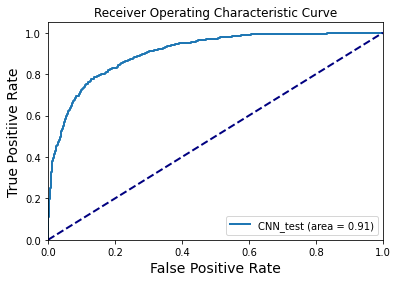

In [ ]:
roc_curve(y_pred, y_label, 'CNN_test.png', 'CNN_test')

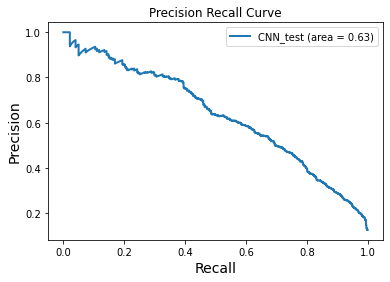

In [ ]:
prauc_curve(y_pred, y_label, 'CNN_test.png', 'CNN_test')